# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [100]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2016-08-30/data_eval_new/"
file_name = "int_norm_20160830_bgd_new.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [101]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [102]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [103]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

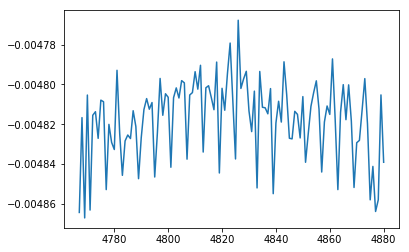

In [104]:
# Check Baselines
column = "116"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

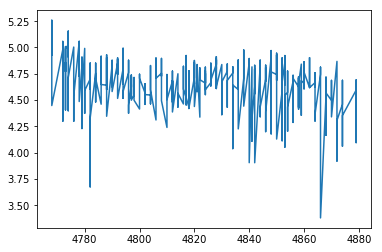

In [105]:
# Check Signals
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

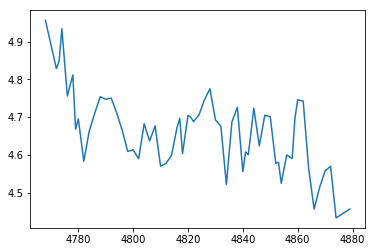

In [106]:
# Check Signals - mean
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

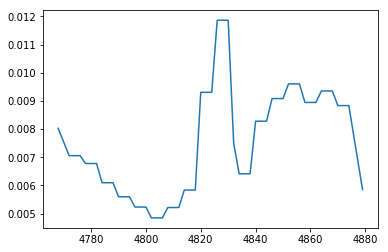

In [107]:
# Check background 
column = "118"
sample = "NIST 200ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [108]:
background_mean = df_mean(background)

# Outlier rejection

In [166]:
bgd_method = "bgd_outlier_corr"
norm_ratio = "r_122_118"
interf_corr = "Te125_Xe129_corr"

In [167]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [168]:
column = "124/118"
sample = "NIST 200ppb"

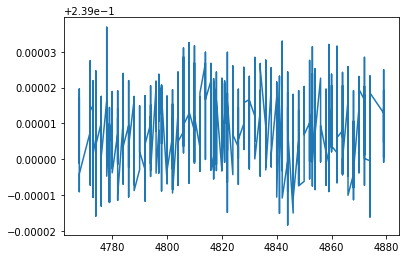

In [169]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [170]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [171]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,,,,,,,
2016-08-30 16:37:00,NIST 200ppb,2,1,4768,0.040145,NaN,0.013942,0.600260,0.316724,0.354636,1.345875,0.19125,0.239008
2016-08-30 16:37:00,NIST 200ppb,2,2,4768,0.040134,0.027172,0.013939,0.600254,0.316724,0.354638,1.345893,0.19125,0.239009
2016-08-30 16:37:00,NIST 200ppb,2,3,4768,0.040135,0.027173,0.013942,0.600249,0.316730,0.354632,1.345921,0.19125,0.239017
2016-08-30 16:37:00,NIST 200ppb,2,4,4768,0.040135,0.027173,0.013943,0.600256,0.316725,0.354643,1.345904,0.19125,0.239007
2016-08-30 16:37:00,NIST 200ppb,2,5,4768,0.040135,0.027174,0.013943,0.600261,0.316725,0.354641,1.345908,0.19125,0.239015
2016-08-30 16:37:00,NIST 200ppb,2,6,4768,0.040136,0.027175,0.013944,0.600255,0.316734,0.354643,1.345915,0.19125,0.239009
2016-08-30 16:37:00,NIST 200ppb,2,7,4768,0.040134,0.027172,0.013942,0.600253,0.316727,0.354638,1.345900,0.19125,0.239007
2016-08-30 16:37:00,NIST 200ppb,2,8,4768,0.040137,0.027169,0.013941,0.600260,0.316735,0.354639,1.345917,0.19125,0.239006
2016-08-30 16:37:00,NIST 200ppb,2,9,4768,0.040138,0.027172,0.013946,0.600288,0.316731,0.354645,1.345910,0.19125,0.239009


In [172]:
df_outlier_raw[df_outlier_raw[column].notnull()][column]

Filenumber  Date               
4768        2016-08-30 16:37:00    0.258074
4772        2016-08-30 17:28:00    0.258048
            2016-08-30 17:28:00    0.257993
            2016-08-30 17:28:00    0.258021
4774        2016-08-30 17:57:00    0.258048
4775        2016-08-30 18:12:00    0.257865
            2016-08-30 18:12:00    0.257914
            2016-08-30 18:12:00    0.257835
4779        2016-08-30 19:08:00    0.258096
4782        2016-08-30 19:52:00    0.257925
4793        2016-08-30 22:26:00    0.258347
            2016-08-30 22:26:00    0.258349
4797        2016-08-30 23:20:00    0.258433
4803        2016-08-31 00:44:00    0.258640
            2016-08-31 00:44:00    0.258449
4805        2016-08-31 01:13:00    0.258397
4806        2016-08-31 01:28:00    0.258456
            2016-08-31 01:28:00    0.258674
            2016-08-31 01:28:00    0.258662
4810        2016-08-31 02:23:00    0.258432
4812        2016-08-31 02:52:00    0.258475
4822        2016-08-31 05:11:00    0.258420


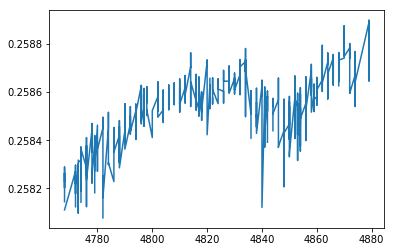

In [173]:
# Check sample measurements
df = df_outlier_rej_raw

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [174]:
df[df["Sample"] == sample][column].std()

0.0001449106338861143

In [175]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

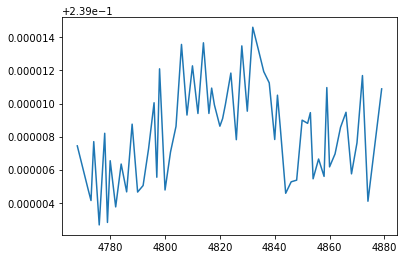

In [176]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [177]:
data_mean_int

,Filenumber,Sample,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,,,,,
2016-08-30 16:37:00,4768,NIST 200ppb,0.040137,0.027172,0.013944,0.600263,0.316733,0.354638,1.345911,0.19125,0.239007
2016-08-30 17:02:00,4770,NIST 350ppb,0.040133,0.027169,0.013944,0.600223,0.316730,0.354856,1.257707,0.19125,0.239014
2016-08-30 17:28:00,4772,NIST 200ppb,0.040137,0.027173,0.013944,0.600270,0.316735,0.354636,1.345922,0.19125,0.239005
2016-08-30 17:43:00,4773,NIST 200ppb,0.040137,0.027171,0.013945,0.600275,0.316735,0.354633,1.345916,0.19125,0.239004
2016-08-30 17:57:00,4774,NIST 200ppb,0.040139,0.027173,0.013944,0.600279,0.316736,0.354637,1.345929,0.19125,0.239008
2016-08-30 18:12:00,4775,NIST 300ppb,0.040142,0.027174,0.013945,0.600304,0.316746,0.354640,1.345967,0.19125,0.239001
2016-08-30 18:27:00,4776,NIST 200ppb,0.040141,0.027173,0.013945,0.600287,0.316738,0.354635,1.345930,0.19125,0.239003
2016-08-30 18:53:00,4778,NIST 200ppb,0.040139,0.027174,0.013944,0.600286,0.316736,0.354647,1.345918,0.19125,0.239008
2016-08-30 19:08:00,4779,NIST 200ppb,0.040139,0.027172,0.013945,0.600294,0.316740,0.354643,1.345927,0.19125,0.239003


In [178]:
date_list = []
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [179]:
drop_sum = []

In [180]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [181]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [182]:
data_mean_int_sum

112/118                   114/118                  \
                               mean       SD2 count      mean       SD2 count   
Sample                                                                          
NIST 200ppb                0.040143  0.000005    62  0.027174  0.000003    62   
NIST 200ppb + 0.005ppb U   0.040141  0.000002     2  0.027173  0.000002     2   
NIST 200ppb + 0.030ppb Cd  0.040142  0.000002     2  0.027175  0.000001     2   
NIST 200ppb + 0.04ppb Cd   0.040144       NaN     1  0.027180       NaN     1   
NIST 200ppb + 0.100ppb Zr  0.040141       NaN     1  0.027173       NaN     1   
NIST 200ppb + 0.150ppb Rh  0.040143       NaN     1  0.027174       NaN     1   
NIST 200ppb + 0.250ppb Pd  0.040144  0.000007     2  0.027176  0.000009     2   
NIST 200ppb + 0.300ppb Ru  0.040142       NaN     1  0.027174       NaN     1   
NIST 200ppb + 0.800ppb Mo  0.040143  0.000004     2  0.027174  0.000002     2   
NIST 200ppb + ME           0.040144       NaN     1  0.027179       NaN     1   
NIST 300ppb                0.040147  0.000004    10  0.027177  0.000003    10   
NIST 350ppb                0.040133       NaN     1  0.027169       NaN     1   
ZH09-05 23.3_1_3           0.040144       NaN     1  0.027176       NaN     1   
ZH09-05 23.3_3b_1          0.040145  0.000002     2  0.027177  0.000002     2   

                            115/118                       116/118  ...   \
                               mean           SD2 count      mean  ...    
Sample                                                             ...    
NIST 200ppb                0.013946  1.640086e-06    62  0.600302  ...    
NIST 200ppb + 0.005ppb U   0.013946  6.745342e-07     2  0.600300  ...    
NIST 200ppb + 0.030ppb Cd  0.013946  1.004249e-06     2  0.600299  ...    
NIST 200ppb + 0.04ppb Cd   0.013945           NaN     1  0.600311  ...    
NIST 200ppb + 0.100ppb Zr  0.013946           NaN     1  0.600302  ...    
NIST 200ppb + 0.150ppb Rh  0.013945           NaN     1  0.600299  ...    
NIST 200ppb + 0.250ppb Pd  0.013946  1.628920e-06     2  0.600303  ...    
NIST 200ppb + 0.300ppb Ru  0.013945           NaN     1  0.600299  ...    
NIST 200ppb + 0.800ppb Mo  0.013946  1.795907e-06     2  0.600298  ...    
NIST 200ppb + ME           0.013946           NaN     1  0.600304  ...    
NIST 300ppb                0.013947  1.440756e-06    10  0.600332  ...    
NIST 350ppb                0.013944           NaN     1  0.600223  ...    
ZH09-05 23.3_1_3           0.013945           NaN     1  0.600299  ...    
ZH09-05 23.3_3b_1          0.013943  2.426574e-06     2  0.600316  ...    

                          119/118   120/118                  122/118  \
                            count      mean       SD2 count     mean   
Sample                                                                 
NIST 200ppb                    62  1.345925  0.000014    62  0.19125   
NIST 200ppb + 0.005ppb U        2  1.345922  0.000009     2  0.19125   
NIST 200ppb + 0.030ppb Cd       2  1.345923  0.000024     2  0.19125   
NIST 200ppb + 0.04ppb Cd        1  1.345935       NaN     1  0.19125   
NIST 200ppb + 0.100ppb Zr       1  1.345927       NaN     1  0.19125   
NIST 200ppb + 0.150ppb Rh       1  1.345931       NaN     1  0.19125   
NIST 200ppb + 0.250ppb Pd       2  1.345922  0.000002     2  0.19125   
NIST 200ppb + 0.300ppb Ru       1  1.345933       NaN     1  0.19125   
NIST 200ppb + 0.800ppb Mo       2  1.345927  0.000010     2  0.19125   
NIST 200ppb + ME                1  1.345935       NaN     1  0.19125   
NIST 300ppb                    10  1.345964  0.000016    10  0.19125   
NIST 350ppb                     1  1.257707       NaN     1  0.19125   
ZH09-05 23.3_1_3                1  1.345962       NaN     1  0.19125   
ZH09-05 23.3_3b_1               2  1.345958  0.000042     2  0.19125   

                                                124/118                  
                                    SD2 count      mean       SD2 count  
S

In [183]:
date_list = []


epsilon_int_200 = SSB(data_mean_int.drop(date_list), "NIST 200ppb", 10000)
delta_raw_200 = SSB(data_mean_raw.drop(date_list), "NIST 200ppb", 1000)

In [184]:

date_list = []

epsilon_int_200 = epsilon_int_200.drop(date_list)
delta_raw_200 = delta_raw_200.drop(date_list)

In [185]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -10) & (df["Filenumber"] <= 10)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [186]:
epsilon_int_200 = epsilon_process(epsilon_int_200)
delta_raw_200 = epsilon_process(delta_raw_200)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [187]:
epsilon_int_200

,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,,,,,
2016-08-30 17:02:00,4770,-0.947946,-1.083782,-0.474568,-0.729795,-0.128316,6.182009,-655.390157,4.440892e-12,0.309999,NIST 350ppb
2016-08-30 17:28:00,4772,-0.066247,0.473194,-0.030995,0.011286,0.031767,0.019303,0.066624,-1.110223e-12,-0.042324,NIST 200ppb
2016-08-30 17:43:00,4773,-0.231359,-0.693771,0.427336,0.007737,-0.005365,-0.100847,-0.072935,0.000000e+00,-0.087903,NIST 200ppb
2016-08-30 17:57:00,4774,0.055293,0.379760,-0.307665,-0.035000,-0.030834,0.085984,0.043956,0.000000e+00,0.179886,NIST 200ppb
2016-08-30 18:12:00,4775,0.511183,0.277780,0.152373,0.347571,0.269213,0.110923,0.276188,0.000000e+00,-0.167644,NIST 300ppb
2016-08-30 18:27:00,4776,0.463027,-0.019250,0.184293,0.073939,0.078806,-0.190779,0.047696,0.000000e+00,-0.221299,NIST 200ppb
2016-08-30 18:53:00,4778,-0.303357,0.316393,-0.303245,-0.068461,-0.104796,0.218496,-0.074801,-1.110223e-12,0.228712,NIST 200ppb
2016-08-30 19:08:00,4779,-0.074380,-0.660671,0.288618,0.140513,0.129345,0.007711,0.020743,2.220446e-12,-0.190869,NIST 200ppb
2016-08-30 19:23:00,4780,-0.163935,0.274857,-0.268727,-0.124863,-0.101947,0.002055,0.018234,-3.330669e-12,0.136516,NIST 200ppb


In [188]:
epsilon_int_200_sum = np.round(epsilon_int_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_200_sum = np.round(delta_raw_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_int_200_sum
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_200_sum
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [189]:
epsilon_sum_all

112/118              114/118              115/118  \
                             mean    SD2 count    mean    SD2 count    mean   
Sample                                                                        
NIST 200ppb                 0.003  0.692    60   0.002  1.001    60  -0.007   
NIST 200ppb + 0.005ppb U   -0.171  1.016     2  -0.017  0.546     2   0.288   
NIST 200ppb + 0.030ppb Cd   0.243  0.286     2   0.978  0.325     2   0.610   
NIST 200ppb + 0.04ppb Cd    0.179    NaN     1   2.364    NaN     1  -0.943   
NIST 200ppb + 0.100ppb Zr  -0.447    NaN     1  -0.625    NaN     1   0.263   
NIST 200ppb + 0.150ppb Rh   0.274    NaN     1   0.831    NaN     1  -0.377   
NIST 200ppb + 0.250ppb Pd   0.576  0.746     2   0.566  2.278     2  -0.521   
NIST 200ppb + 0.300ppb Ru  -0.134    NaN     1   0.109    NaN     1  -0.876   
NIST 200ppb + 0.800ppb Mo   0.252  0.480     2  -0.276  1.516     2  -0.010   
NIST 200ppb + ME            0.111    NaN     1   1.618    NaN     1   0.804   
NIST 300ppb                 0.727  0.623    10   0.684  0.540    10   0.612   
NIST 350ppb                -0.948    NaN     1  -1.084    NaN     1  -0.475   
ZH09-05 23.3_1_3           -0.083    NaN     1  -0.022    NaN     1  -0.962   
ZH09-05 23.3_3b_1           0.206  1.326     2   0.550  0.466     2  -1.464   

                                       116/118  ...  119/118  120/118         \
                             SD2 count    mean  ...    count     mean    SD2   
Sample                                          ...                            
NIST 200ppb                0.976    60   0.002  ...       60    0.002  0.108   
NIST 200ppb + 0.005ppb U   0.347     2  -0.008  ...        2   -0.009  0.038   
NIST 200ppb + 0.030ppb Cd  0.374     2   0.031  ...        2    0.030  0.155   
NIST 200ppb + 0.04ppb Cd     NaN     1   0.002  ...        1    0.092    NaN   
NIST 200ppb + 0.100ppb Zr    NaN     1   0.005  ...        1    0.036    NaN   
NIST 200ppb + 0.150ppb Rh    NaN     1  -0.038  ...        1    0.062    NaN   
NIST 200ppb + 0.250ppb Pd  0.782     2   0.069  ...        2   -0.021  0.074   
NIST 200ppb + 0.300ppb Ru    NaN     1  -0.077  ...        1    0.120    NaN   
NIST 200ppb + 0.800ppb Mo  0.184     2   0.005  ...        2    0.074  0.037   
NIST 200ppb + ME             NaN     1   0.034  ...        1    0.053    NaN   
NIST 300ppb                0.556    10   0.464  ...       10    0.252  0.130   
NIST 350ppb                  NaN     1  -0.730  ...        1 -655.390    NaN   
ZH09-05 23.3_1_3             NaN     1  -0.144  ...        1    0.316    NaN   
ZH09-05 23.3_3b_1          1.589     2   0.102  ...        2    0.257  0.284   

                                122/118            124/118               
                          count    mean  SD2 count    mean    SD2 count  
Sample                                                                   
NIST 200ppb                  60     0.0  0.0    60  -0.003  0.274    60  
NIST 200ppb + 0.005ppb U      2    -0.0  0.0     2   0.017  0.076     2  
NIST 200ppb + 0.030ppb Cd     2    -0.0  0.0     2   0.009  0.132     2  
NIST 200ppb + 0.04ppb Cd      1    -0.0  NaN     1  -0.072    NaN     1  
NIST 200ppb + 0.100ppb Zr     1    -0.0  NaN     1   0.017    NaN     1  
NIST 200ppb + 0.150ppb Rh     1    -0.0  NaN     1  -0.059    NaN     1  
NIST 200ppb + 0.250ppb Pd     2     0.0  0.0     2  -0.068  0.172     2  
NIST 200ppb + 0.300ppb Ru     1     0.0  NaN     1   0.161    NaN     1  
NIST 200ppb + 0.800ppb Mo     2     0.0  0.0     2   0.025  0.123     2  
NIST 200ppb + ME              1     0.0  NaN     1  -0.143    NaN     1  
NIST 300ppb                  10     0.0  0.0    10  -0.116  0.144    10  
NIST 350ppb                   1     0.0  NaN     1   0.310    NaN     1  
ZH09-05 23.3_1_3              1     0.0  NaN     1   0.028    NaN     1  
ZH09-05 23.3_3b_1             2     0.0  0.0     2  -0.055  0.018     2  

[14 rows x 27 columns]

In [133]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [ ]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

# Raw data to xls file

In [134]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [135]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [190]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_new.xlsx', engine='xlsxwriter')


In [191]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_200.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_200.to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [192]:
writer_orig.save()

In [230]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

NameError: name 'hdf5_sum_file' is not defined

In [193]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')